# Diffusion Model for Video Super Resolution

Inspiration gathered from:

https://github.com/CompVis/latent-diffusion

https://ar5iv.labs.arxiv.org/html/2311.15908

In [1]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F # provides functions that don't need to be in a computational graph, i.e. aren't part of a NN, usually for single-use
import torchvision
from torch.utils.data import DataLoader, Dataset
from model import *
import matplotlib.pyplot as plt
import time as time
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
torchvision.__version__

'0.17.2+cu121'

In [3]:
# datasets with _sharp are the correct/ground truth images
# datasets with _blur_bicubic are those that have been blurred and
# downsampled using bicubic interpolation
datasets = ['train_sharp', 'train_blur_bicubic', 'val_sharp', 'val_blur_bicubic']
for set in datasets:
    print(set)
    if not os.path.isfile(f"REDS/{set}.zip"):
        # print("Downloading")
        cmdlet = f"python download_REDS.py --{set}"
        print(cmdlet)
        os.system(cmdlet)
# if not already downloaded, this will download all datasets (takes a while)
        

train_sharp
train_blur_bicubic
val_sharp
val_blur_bicubic


In [4]:
# Set up data into dataset and dataloader
# It assumes the project file structure as downloaded from above
# Built based on docs: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class REDS(Dataset):
    def __init__(self, train=True, device='cuda'):
        self.device = device
        self.type = 'train' if train else 'test' 
        if self.type == 'train':
            self.hr_dir = "REDS/train_sharp/train/train_sharp"
            self.lr_dir = "REDS/train_blur_bicubic/train/train_blur_bicubic/X4"
        else:
            self.hr_dir = "REDS/val_sharp/val/val_sharp"
            self.lr_dir = "REDS/val_blur_bicubic/val/val_blur_bicubic/X4"
            
    def __len__(self):
        return len(os.listdir(self.hr_dir)) # training size = 240 videos, testing size = 30 videos
            
    def __getitem__(self, idx):
        # each return gives a single HR frame with 5 corresponding LR frames
        # the middle LR frame (frame 3) will be the blurred/downsampled version of the HR frame
        # the 5 sequential LR frames will be chosen randomly from the given idx-video
        
        # Getting video sequence folder name
        if idx < 10:
            video = '00' + str(idx)
        elif idx < 100:
            video = '0' + str(idx)
        else:
            video = str(idx)
        # Getting random sequence of 5 LR frames from the video    
        num_video_frames = len(os.listdir(f"{self.hr_dir}/000"))
        rand_frame_id = np.random.randint(2, num_video_frames - 2)
        lr_frame_idx = []
        for i in range(-2, 3):
            id_int = rand_frame_id + i
            if id_int < 10:
                id_str = '0000000' + str(id_int)
            elif id_int < 100:
                id_str = '000000' + str(id_int)
            else:
                id_str = '00000' + str(id_int)
            lr_frame_idx.append(id_str)
        # Actually reading in the images
        hr_frame = torchvision.io.read_image(f"{self.hr_dir}/{video}/{lr_frame_idx[2]}.png").to(self.device)
        lr_frames = []
        for v in lr_frame_idx:
            lr_frame = torchvision.io.read_image(f"{self.lr_dir}/{video}/{v}.png").to(self.device)
            lr_frames.append(lr_frame)
        lr_frames = torch.stack(lr_frames).permute(1, 0, 2, 3)
        # hr_frame is of size 3x720x1280 (CxHxW)
        # lr_imgs of of size 5x3x180x320 (TxCxHxW)
        # where C=channel, T=time (video sequence)
        return torch.tensor(lr_frames).float(), hr_frame.float()

In [5]:
train_dataset = REDS(train=True, device=device)
test_dataset = REDS(train=False, device=device)
# Using the customizable PyTorch dataset allows us to use dataloaders, iterable objects for training/testing that
# make it so easy!
# train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)
# Show an example of getting data from either of the datasets
# Top is high-res image, bottom is blurred/downsampled low-res image equivalent
lr_imgs, hr_img = train_dataset.__getitem__(25)
# plt.imshow(hr_img.permute(1,2,0).cpu())
# plt.show()
# plt.imshow(lr_imgs[2].permute(1,2,0).cpu())
# plt.show()
"""
if matplotlib doesn't run, go into the envs/pytorch_vsr environment in anaconda3
and delete all version of libiomp5md.dll , and it should work
"""

"\nif matplotlib doesn't run, go into the envs/pytorch_vsr environment in anaconda3\nand delete all version of libiomp5md.dll , and it should work\n"

In [6]:
# Set up loss functions

# perceptual_loss
vgg = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features # removes final classification layer as we don't need it
vgg.to(device)
vgg.eval() # sets the model to evaluation mode, to not update weights/parameters
for param in vgg.parameters():
    param.requires_grad = False # don't calculate gradients after forward passes, reduces computation
    
# A hook function can be used on any nn.module(), like any layer of a neural net
# Depending on whether it's a backwards hook (backprop) or forward hook (forward pass),
# the inputs and outputs of that nn.module can be accessed for that operation
# It's like an event, that each time it happens, the inputs/outputs of that module are saved and then used by vgg_hook
vgg_activations = {3:torch.tensor(0),
                   8:torch.tensor(0),
                   17:torch.tensor(0),
                   26:torch.tensor(0),
                   35:torch.tensor(0)}
def vgg_hook(module, input, output):   
    # Get activations at several layers
    for layer in [3, 8, 17, 26, 35]: # each of the layers we want
        if module == vgg[layer]: 
            vgg_activations[layer] = output
    
for layer in [3, 8, 17, 26, 35]:
    vgg[layer].register_forward_hook(vgg_hook)

def perceptual_loss(generated_img, target_img): # we want a lower value
    _ = vgg(generated_img)
    generated_activations = vgg_activations.copy()
    _ = vgg(target_img)
    target_activations = vgg_activations.copy()
    
    # calculate F1 (mean absolute loss (MAE)) for each activation layer
    mae_loss = []
    for layer in [3, 8, 17, 26, 35]:
        mae = F.l1_loss(generated_activations[layer],
                        target_activations[layer])
        mae_loss.append(mae)
    
    return sum(mae_loss)

# Test if perceptual loss works
lr_imgs1, hr_img1 = train_dataset.__getitem__(25)
lr_imgs2, hr_img2 = train_dataset.__getitem__(30)

print(f"Differing video sequences: {perceptual_loss(hr_img1.float(), hr_img2.float())}")
print(f"Same frame: {perceptual_loss(hr_img2.float(), hr_img2.float())}")

Differing video sequences: 199.22418212890625
Same frame: 0.0


In [10]:
# Parameters for training/testing
new_model = True
num_epochs = 8
learning_rate = 0.001
train=True # if false, then the models will initialize with best weights (for inference/testing)

In [ ]:
torch.cuda.empty_cache()
# Can be either 'mse' or 'pq'
loss_function = 'pq'
path = f'saved_models/diff_model_{loss_function}.pt'
# Initialize Model architecture
pq_diff_model = diffusion_vsr(s=torch.tensor(0.0008), 
                           train_T=torch.tensor(1000), 
                           infer_T=torch.tensor(50)).to(device)
if new_model:
    # Train/Test 
    # Mean Square Error/Perceptual Quality
    train_mse_loss = []
    train_pq_loss = []
    test_mse_loss = []
    test_pq_loss = []
    best_val_loss = float('inf')
else:
    # Get dictionary of info
    old_model = torch.load(path, map_location=device)
    # load model with previous weights/parameters
    pq_diff_model.load_state_dict(old_model[0])
    # update previous lists of loss
    if loss_function == 'mse':
        train_mse_loss = old_model[1]
        test_mse_loss = old_model[2]
    else:
        train_pq_loss = old_model[1]
        test_pq_loss = old_model[2]
    best_val_loss = old_model[3]
    
if train:
    start_time = time.time()
    mse = nn.MSELoss()
    optimizer = torch.optim.Adam(params=pq_diff_model.parameters(),
                                 lr=learning_rate)
    for epoch in range(num_epochs):
        # Training
        pq_diff_model.train()
        pq_diff_model.calc_train_steps()
        running_loss = 0
        for i in range(train_dataset.__len__()):
            lr_imgs, hr_img = train_dataset.__getitem__(i)
            # random t-step to predict
            t = torch.randint(low=0, high=50, size=(1,)).to(device)
            # hr_img after t steps of noise addition
            hr_t = pq_diff_model.add_noise(hr_img, t)
            # hr_img after t-1 steps of noise addition
            # This is what we want the model to predict (bc we want the reverse process)
            hr_tmin1 = pq_diff_model.add_noise(hr_img, t-1)
            # Now, let's do one pass through the model
            pred_hr_tmin1 = pq_diff_model(hr_t, lr_imgs, t)
            if loss_function == 'mse':
                loss = mse(pred_hr_tmin1, hr_tmin1)
            else:
                loss = perceptual_loss(pred_hr_tmin1, hr_tmin1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_running_loss = running_loss / train_dataset.__len__()
        if loss_function == 'mse':
            train_mse_loss.append(avg_running_loss)
        else:
            train_pq_loss.append(avg_running_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Training Loss: {avg_running_loss:.4f}')
            
        # Testing
        pq_diff_model.eval()
        pq_diff_model.calc_test_steps()
        running_loss = 0
        for i in range(test_dataset.__len__()):
            with torch.no_grad():
                lr_imgs, hr_img = test_dataset.__getitem__(i)
                # random t-step to predict
                t = torch.randint(low=0, high=50, size=(1,)).to(device)
                # hr_img after t steps of noise addition
                hr_t = pq_diff_model.add_noise(hr_img, t)
                # hr_img after t-1 steps of noise addition
                # This is what we want the model to predict (bc we want the reverse process)
                hr_tmin1 = pq_diff_model.add_noise(hr_img, t-1)
                # Now, let's do one pass through the model
                pred_hr_tmin1 = pq_diff_model(hr_t, lr_imgs, t)
                if loss_function == 'mse':
                    loss = mse(pred_hr_tmin1, hr_tmin1)
                else:
                    loss = perceptual_loss(pred_hr_tmin1, hr_tmin1)
                running_loss += loss.item()
            
        avg_running_loss = running_loss / test_dataset.__len__()
        if loss_function == 'mse':
            test_mse_loss.append(avg_running_loss)
        else:
            test_pq_loss.append(avg_running_loss)
        
        # Capture results
        if avg_running_loss < best_val_loss:
            # print(avg_running_loss, best_val_loss)
            best_val_loss = avg_running_loss
            save_dict = dict()
            save_dict[0] = pq_diff_model.state_dict()
            if loss_function == 'mse':
                save_dict[1] = train_mse_loss
                save_dict[2] = test_mse_loss
            else:
                save_dict[1] = train_pq_loss
                save_dict[2] = test_pq_loss
            save_dict[3] = best_val_loss
            torch.save(save_dict, path)
            
        # Calculate epoch training/testing time
        if epoch==0:
            prev_time = start_time
        else:
            prev_time = curr_time    
        curr_time = time.time()
        time_diff = (curr_time - prev_time) # in seconds
        minutes, seconds = divmod(time_diff, 60)
        minutes = int(minutes)
        seconds = int(seconds)
        
        print(f'Testing Loss:  {avg_running_loss:.4f}')
        print(f'Time:')
        print(f'{minutes} minutes:{seconds} seconds')
        print()

In [ ]:
# Plotting avg. training and testing loss for MSE-trained model
plt.plot(train_pq_loss)
plt.plot(test_pq_loss)
plt.title("Pereceptual Loss")
plt.legend(['Train', 'Test'])

In [8]:
torch.cuda.empty_cache()
# Can be either 'mse' or 'pq'
loss_function = 'mse'
path = f'saved_models/diff_model_{loss_function}.pt'
# Initialize Model architecture
mse_diff_model = diffusion_vsr(s=torch.tensor(0.0008), 
                           train_T=torch.tensor(1000), 
                           infer_T=torch.tensor(50)).to(device)
if new_model:
    # Train/Test 
    # Mean Square Error/Perceptual Quality
    train_mse_loss = []
    train_pq_loss = []
    test_mse_loss = []
    test_pq_loss = []
    best_val_loss = float('inf')
else:
    # Get dictionary of info
    old_model = torch.load(path, map_location=device)
    # load model with previous weights/parameters
    mse_diff_model.load_state_dict(old_model[0])
    # update previous lists of loss
    if loss_function == 'mse':
        train_mse_loss = old_model[1]
        test_mse_loss = old_model[2]
    else:
        train_pq_loss = old_model[1]
        test_pq_loss = old_model[2]
    best_val_loss = old_model[3]
    
if train:
    start_time = time.time()
    mse = nn.MSELoss()
    optimizer = torch.optim.Adam(params=mse_diff_model.parameters(),
                                 lr=learning_rate)
    for epoch in range(num_epochs):
        # Training
        mse_diff_model.train()
        mse_diff_model.calc_train_steps()
        running_loss = 0
        for i in range(train_dataset.__len__()):
            lr_imgs, hr_img = train_dataset.__getitem__(i)
            # random t-step to predict
            t = torch.randint(low=0, high=50, size=(1,)).to(device)
            # hr_img after t steps of noise addition
            hr_t = mse_diff_model.add_noise(hr_img, t)
            # hr_img after t-1 steps of noise addition
            # This is what we want the model to predict (bc we want the reverse process)
            hr_tmin1 = mse_diff_model.add_noise(hr_img, t-1)
            # Now, let's do one pass through the model
            pred_hr_tmin1 = mse_diff_model(hr_t, lr_imgs, t)
            if loss_function == 'mse':
                loss = mse(pred_hr_tmin1, hr_tmin1)
            else:
                loss = perceptual_loss(pred_hr_tmin1, hr_tmin1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_running_loss = running_loss / train_dataset.__len__()
        if loss_function == 'mse':
            train_mse_loss.append(avg_running_loss)
        else:
            train_pq_loss.append(avg_running_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Training Loss: {avg_running_loss:.4f}')
            
        # Testing
        mse_diff_model.eval()
        mse_diff_model.calc_test_steps()
        running_loss = 0
        for i in range(test_dataset.__len__()):
            with torch.no_grad():
                lr_imgs, hr_img = test_dataset.__getitem__(i)
                # random t-step to predict
                t = torch.randint(low=0, high=50, size=(1,)).to(device)
                # hr_img after t steps of noise addition
                hr_t = mse_diff_model.add_noise(hr_img, t)
                # hr_img after t-1 steps of noise addition
                # This is what we want the model to predict (bc we want the reverse process)
                hr_tmin1 = mse_diff_model.add_noise(hr_img, t-1)
                # Now, let's do one pass through the model
                pred_hr_tmin1 = mse_diff_model(hr_t, lr_imgs, t)
                if loss_function == 'mse':
                    loss = mse(pred_hr_tmin1, hr_tmin1)
                else:
                    loss = perceptual_loss(pred_hr_tmin1, hr_tmin1)
                running_loss += loss.item()
            
        avg_running_loss = running_loss / test_dataset.__len__()
        if loss_function == 'mse':
            test_mse_loss.append(avg_running_loss)
        else:
            test_pq_loss.append(avg_running_loss)
        
        # Capture results
        if avg_running_loss < best_val_loss:
            # print(avg_running_loss, best_val_loss)
            best_val_loss = avg_running_loss
            save_dict = dict()
            save_dict[0] = mse_diff_model.state_dict()
            if loss_function == 'mse':
                save_dict[1] = train_mse_loss
                save_dict[2] = test_mse_loss
            else:
                save_dict[1] = train_pq_loss
                save_dict[2] = test_pq_loss
            save_dict[3] = best_val_loss
            torch.save(save_dict, path)
            
        # Calculate epoch training/testing time
        if epoch==0:
            prev_time = start_time
        else:
            prev_time = curr_time    
        curr_time = time.time()
        time_diff = (curr_time - prev_time) # in seconds
        minutes, seconds = divmod(time_diff, 60)
        minutes = int(minutes)
        seconds = int(seconds)
        
        print(f'Testing Loss:  {avg_running_loss:.4f}')
        print(f'Time:')
        print(f'{minutes} minutes:{seconds} seconds')
        print()

KeyboardInterrupt: 

In [ ]:
# Plotting avg. training and testing loss for MSE-trained model
plt.plot(train_mse_loss)
plt.plot(test_mse_loss)
plt.title("MSE Loss")
plt.legend(['Train', 'Test'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


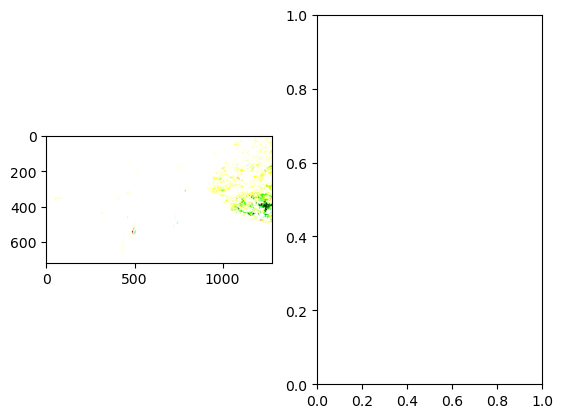

In [17]:
lr_imgs, hr_img = test_dataset.__getitem__(0)
hr_pred = pq_diff_model.full_inference(lr_imgs)
fig, axes = plt.subplots(1,2)
axes[0].imshow(hr_img.permute(1,2,0).cpu().detach().numpy())

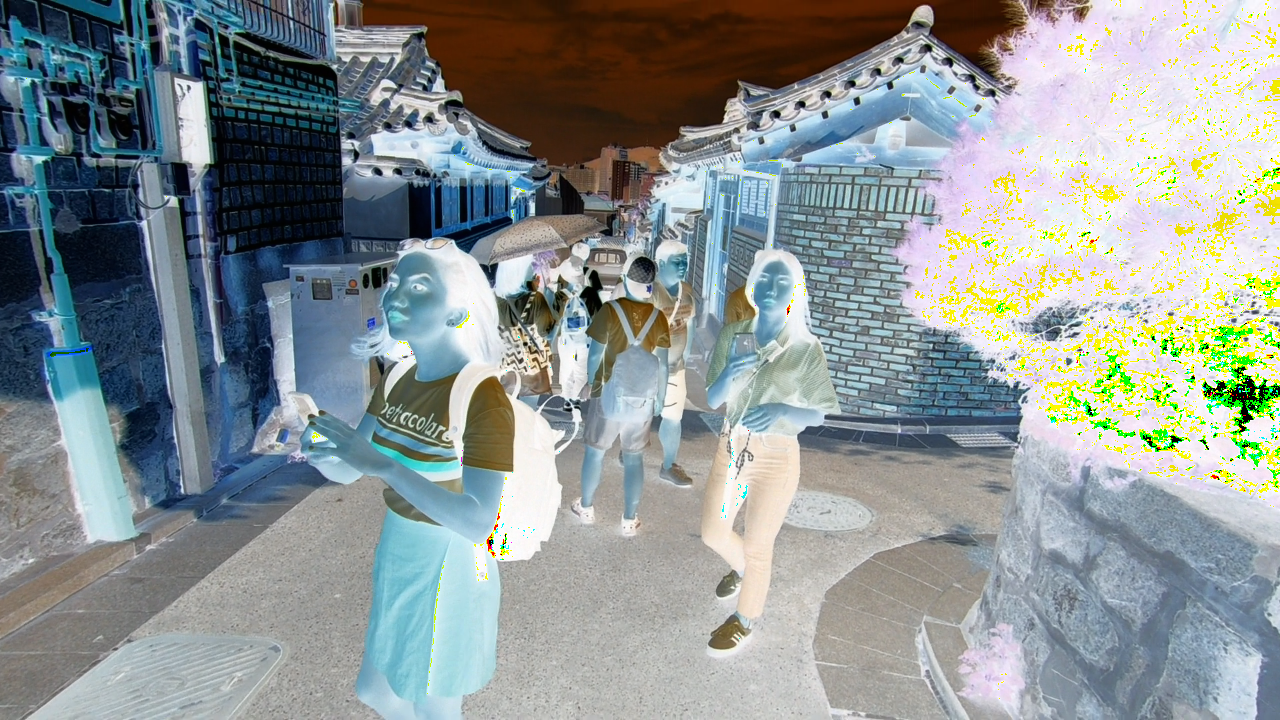

In [19]:
torchvision.transforms.ToPILImage()(hr_img)


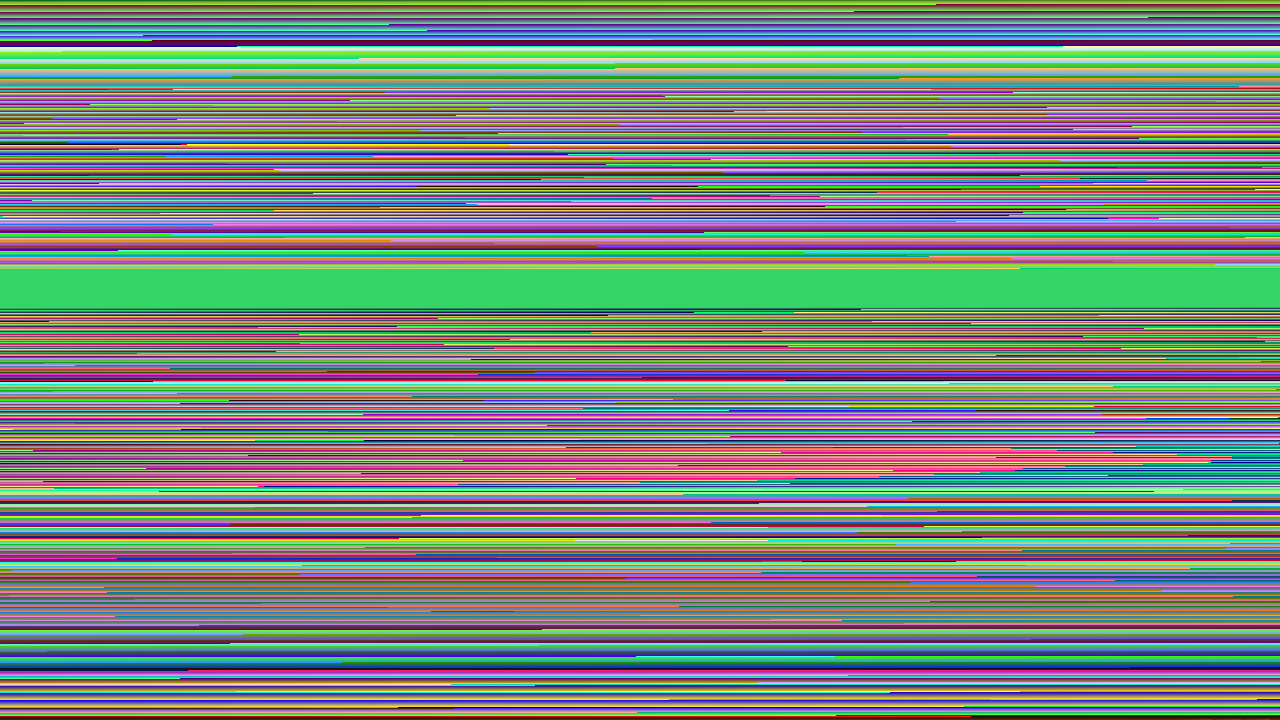

In [20]:
torchvision.transforms.ToPILImage()(hr_pred)